# Problem Set 3 - Linear Regression, Logistic Regression, and Naive Bayes Classifier
## CSCI 4622 - Spring 2023
***
**Name**: Alex Ojemann
***

This assignment is due on Canvas by **11:59PM on March 8th**.

Submit only this Jupyter notebook to Canvas with the name format `PS3_<yourname>.ipynb`. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question. You can add a write-up markdown cell if it wasn't provided.

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to previous homeworks.
***

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import data
%matplotlib inline

## Problem 1: Linear Regression (40 points)
For this problem we will be working with data on the compressive strength of concrete. The compressive strength of this ubiquitous material is a function of its age and ingredients.

We will use linear regression models to predict the compressive strength (in megapascals) from the following features:

| Feature            | About                            |
|--------------------|----------------------------------|
| Cement             | component 1, kg in 1 m^3 mixture |
| Blast Furnace Slag | component 2, kg in 1 m^3 mixture |
| Fly Ash            | component 3, kg in 1 m^3 mixture |
| Water              | component 4, kg in 1 m^3 mixture |
| Superplasticizer   | component 5, kg in 1 m^3 mixture |
| Coarse Aggregate   | component 6, kg in 1 m^3 mixture |
| Fine Aggregate     | component 7, kg in 1 m^3 mixture |
| Age                | component 8, days                |

First, we want to scale the prices to the interval $[0, 1]$ using `MinMaxScaler`. Given an features matrix $X$, the scaling works as follows:
\begin{align}
    X  \leftarrow \frac{X-min(X)}{max(X) - min(X)}
\end{align}

this is performed as a column-wise operation (column = feature).

As usual, $min(X)$ and $max(X)$ are computed on the training set.

- Q1.1.a **[3 points]** Complete `MinMaxScaler.fit` to compute and save the feature-wise min and max.
- Q1.1.b **[2 points]** Complete `MinMaxScaler.transform` to apply the min-max scaling using the computed statistics.

In [42]:
class MinMaxScaler:

    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, X):
        """
        Compute and save the features min and max of shape (num_features,)
        (you can also save them with shape (1, num_features))
        :param X: array of shape (num_samples, num_features)
        :return: fitted scaler
        """
        # Workspace 1.1.a
        #BEGIN 
        # code here
        self.min = np.min(X, axis=0)
        self.max = np.max(X, axis=0)

        #END
        return self

    def transform(self, X):
        """
        Transform the given samples using the precomputed min and max
        :param X: np.array of shape (num_samples, num_features)
        :return: MinMax scaled X, of shape (num_samples, num_features)
        """
        # Workspace 1.1.b
        #BEGIN 
        # code here
        X_scaled = (X - self.min) / (self.max - self.min)

        return X_scaled
        #END

    def fit_transform(self, X):
        """
        Fit using X and then transform it. Useful when we need to scale just once.
        """
        self.fit(X)
        return self.transform(X)

In [43]:
%run -i tests scaler

...
----------------------------------------------------------------------
Ran 3 tests in 0.005s

OK


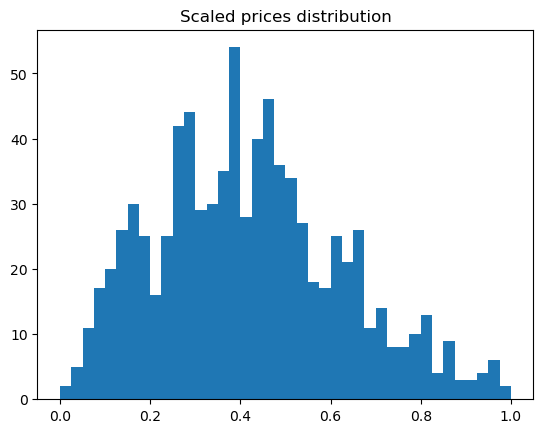

In [44]:
concrete_data = data.Concrete()
minmax_scaler = MinMaxScaler()
# MinMax works on 2-d arrays, so we just need to parse the prices as a single column/feature
# and then squeeze it back to 1-d array
concrete_data.y_train = minmax_scaler.fit_transform(concrete_data.y_train[:, None])[:, 0]
concrete_data.y_test = minmax_scaler.transform(concrete_data.y_test[:, None])[:, 0]
plt.hist(concrete_data.y_train, bins=40)
plt.title("Scaled prices distribution")
plt.show()

We have seen that Ridge regression adds a regularization term to the least square using the L2 norm.
Ridge regression is part of scikit-learn package ([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)), but we will be building our own implementation.

The objective of Ridge regression is to minimize:

\begin{align}
\frac{1}{N}\sum_{i=1}^{N} ||y_i-\mathbf{w}^T \mathbf{x_i}-\mathbf{b}||^2 + \alpha||\mathbf{w}||^2
\end{align}

where $\mathbf{w}$ denotes the coefficients vector for the linear regression model,
$\mathbf{b}$ the intercept vector, $\alpha$ the trade-off regularization parameter, and $N$ the number of samples.



A common practice is to scale or normalize (usually normalize) the features before fitting the model. It allows a _fair_ treatment of different features.
You are allowed to use scikit's `StandardScaler` to do the normalization (yes, a thing called scaler is normalizing. Don't @ me, @ sklearn). Do not forget to run the same transformation on the test data before running the prediction.

- Q1.2 **[5 points]** Complete the `fit` by storing the coefficients $w$ and the intercept $b$ in the corresponding attribute and returning number on non-zero elements of $w$ and $||w||$
- Q1.3 **[5 points]** Complete `evaluate` method to compute the RMSE of the model on the provided data **without using `model.predict`**

In [45]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler


class Ridge(object):

    def __init__(self, alpha, normalize=False):
        """ Initialize ridge
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """

        self.alpha = alpha  # our tuning / regularization parameter
        self.coefficients = None  # our weights vector, w (in formulae above)
        self.intercept = None  # our intercept parameter, b (in formulae above)
        self.normalize = normalize  # boolean whether to normalize the features or not
        self.scaler = StandardScaler()  # method by which to normalize the features (depends on self.normalize)
        self.model = linear_model.Ridge(alpha=alpha, fit_intercept=True)

    def fit(self, X, y):
        """
        Fit the ridge model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (num_samples, num_features)
        :param y: target values (num_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """
        num_nonzero_coefs, coef_norm = None, None
        # Workspace 1.2
        # TO DO: compute w and b and store them in self.coefficients and self.intercept
        # HINT: use self.scaler first, if and only if self.normalize is True
        #BEGIN 
        # code here
        if self.normalize:
            X = self.scaler.fit_transform(X)

        # fit the model
        self.model.fit(X, y)

        # save coefficients and intercept
        self.coefficients = self.model.coef_
        self.intercept = self.model.intercept_

        # calculate number of non-zero coefficients and coefficient norm
        num_nonzero_coefs = np.count_nonzero(self.coefficients)
        coef_norm = np.linalg.norm(self.coefficients)
        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, X, y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values of the test data
        :param X: instances array of shape (num_samples, num_features)
        :param y: the true targets, of shape (num_samples)
        :return: RMSE
        """

        # Workspace 1.3
        # TO DO: predict based on the test features and return the root mean squared error
        #BEGIN 
        # code here
        if self.normalize:
            X = self.scaler.transform(X)

        y_pred = self.model.predict(X)

        root_mean_squared_error = np.sqrt(np.mean((y - y_pred) ** 2))
        #END
        return root_mean_squared_error

In [46]:
# Tests cells, do not remove
# Should run without errors
%run -i tests ridge

....
----------------------------------------------------------------------
Ran 4 tests in 0.010s

OK


<Figure size 640x480 with 0 Axes>

- Q1.4 **[4 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized Ridge:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell. What is the best `alpha` for each version of the two models?

To produce multiple plots in the same figure, see the examples [here](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html)

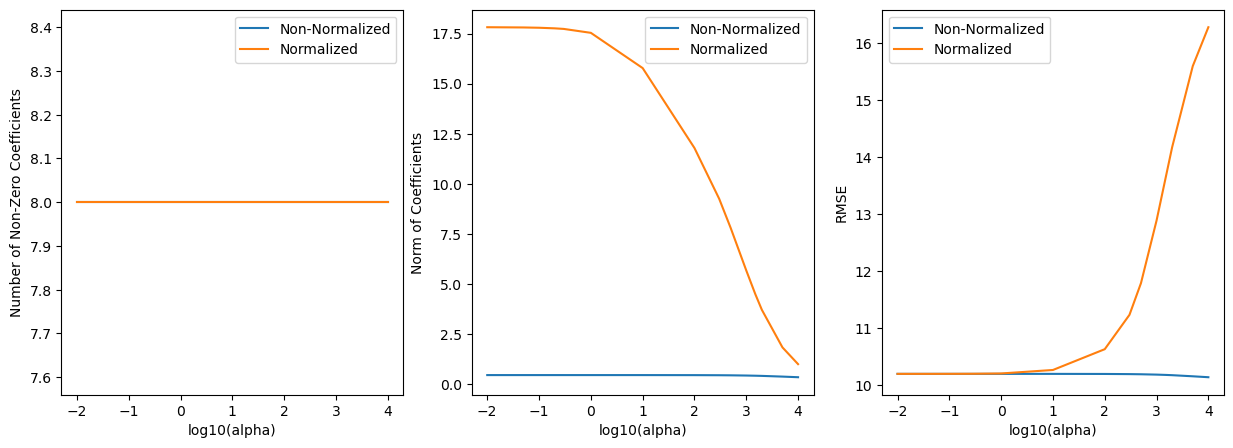

In [47]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 1.0, 10.0, 100.0, 300.0, 500.0, 1e3, 1.5e3, 2e3, 5e3, 1e4]
# Workspace 1.4
#BEGIN 
# code here
concrete_data = data.Concrete()
ridge_non_norm = None
ridge_norm = None

# Initialize lists to store the results for each alpha value
non_zero_coefs_non_norm = []
coef_norm_non_norm = []
rmse_non_norm = []
non_zero_coefs_norm = []
coef_norm_norm = []
rmse_norm = []
for alpha in alphas:
    # Fit the non-normalized model
    ridge_non_norm = Ridge(alpha,normalize=False)
    coefs, norm = ridge_non_norm.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_coefs_non_norm.append(coefs)
    coef_norm_non_norm.append(norm)
    rmse_non_norm.append(ridge_non_norm.evaluate(concrete_data.X_test,concrete_data.y_test))

    # Fit the normalized model
    ridge_norm = Ridge(alpha,normalize=True)
    coefs, norm = ridge_norm.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_coefs_norm.append(coefs)
    coef_norm_norm.append(norm)
    rmse_norm.append(ridge_norm.evaluate(concrete_data.X_test,concrete_data.y_test))

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(np.log10(alphas), non_zero_coefs_non_norm, label='Non-Normalized')
axs[0].plot(np.log10(alphas), non_zero_coefs_norm, label='Normalized')
axs[0].set_xlabel('log10(alpha)')
axs[0].set_ylabel('Number of Non-Zero Coefficients')
axs[0].legend()

axs[1].plot(np.log10(alphas), coef_norm_non_norm, label='Non-Normalized')
axs[1].plot(np.log10(alphas), coef_norm_norm, label='Normalized')
axs[1].set_xlabel('log10(alpha)')
axs[1].set_ylabel('Norm of Coefficients')
axs[1].legend()

axs[2].plot(np.log10(alphas), rmse_non_norm, label='Non-Normalized')
axs[2].plot(np.log10(alphas), rmse_norm, label='Normalized')
axs[2].set_xlabel('log10(alpha)')
axs[2].set_ylabel('RMSE')
axs[2].legend()
#END

#### Workspace 1.4b
#BEGIN

The lowest RMSE for the non normalized model appears to be at alpha = 1e4 while the lowest RMSE for the normalized model appears to be anywhere between alpha = 0.01 and alpha = 1.

#END

Based on the results from previous questions, you should have noticed that the interpretation of Ridge regression is not an easy task.
One way to solve that is to use a regularization that adds _sparsity_ to $\mathbf w$ and excludes less important features.
That's what Lasso regression is about.

Lasso uses $l_1$ norm in the regularization term and minimizes:
\begin{align}
\frac{1}{2N}\sum_i ||y_i-\mathbf{w}^T \mathbf{x}_i -\mathbf{b}||^2 + \alpha||\mathbf{w}||_1
\end{align}

It is part of scikit package ([more details](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html))



- Q1.5 **[5 points]** Complete the Lasso class in the same way Ridge class was created. (You're allowed to use inheritance for a more concise code, as long as the class has `coefficients` and `intercept` attributes.)

In [48]:
class Lasso(object):
    def __init__(self, alpha, normalize=False):
        """ Lasso Regression
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not

        """
        self.alpha = alpha  # our tuning / regularization parameter
        self.coefficients = None  # our weights vector, w (in formulae above)
        self.intercept = None  # our intercept parameter, b (in formulae above)
        self.normalize = normalize  # boolean whether to normalize the features or not
        self.scaler = StandardScaler()  # method by which to normalize the features (depends on self.normalize)
        self.model = linear_model.Lasso(alpha=alpha, fit_intercept=True)

    def fit(self, X, y):
        """
        Fit the lasso model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (num_samples, num_features)
        :param y: target values (num_samples)
        :return: tuple (number of non-zeros coefficients of w: scalar, norm of w: scalar)
        """

        num_nonzero_coefs, coefs_norm = 0, 0
        # Workspace 1.5.a
        # TO DO: compute w and b and store then in self.coefficients and self.intercept
        # TO DO: call lasso_path on the centered features to compute self.coefficients
        # HINT: use self.scaler first, if and only if self.normalize is True
        #BEGIN 
        # code here
        num_nonzero_coefs, coefs_norm = 0, 0
        if self.normalize:
            X = self.scaler.fit_transform(X)

        self.model.fit(X, y)

        # Number of non-zero coefficients
        num_nonzero_coefs = np.count_nonzero(self.model.coef_)

        # Coefficients norm
        coefs_norm = np.linalg.norm(self.model.coef_)

        self.coefficients = self.model.coef_
        self.intercept = self.model.intercept_
        #END
        return num_nonzero_coefs, coefs_norm

    def evaluate(self, X, y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param X: features array, shape (num_samples, num_features)
        :param y: true targets, shape (num_samples)
        :return: RMSE
        """
        root_mean_squared_error = 0
        # Workspace 1.5.b
        # TO DO: predict based on the test features and return the mean_squared_error
        #BEGIN 
        # code here
        if self.normalize:
            X = self.scaler.transform(X)

        y_pred = self.model.predict(X)
        root_mean_squared_error = np.sqrt(np.mean((y - y_pred) ** 2))
        #END
        return root_mean_squared_error

In [49]:
# Tests cell, do not remove
# Test non-normalized Lasso
%run -i tests lasso

....
----------------------------------------------------------------------
Ran 4 tests in 0.010s

OK


<Figure size 640x480 with 0 Axes>

- Q1.6 **[4 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized Lasso:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell. What is the best `alpha` for each version of the two models?

Can you get all coefficients of $\mathbf w$ to 0 for the non-normalized Lasso?


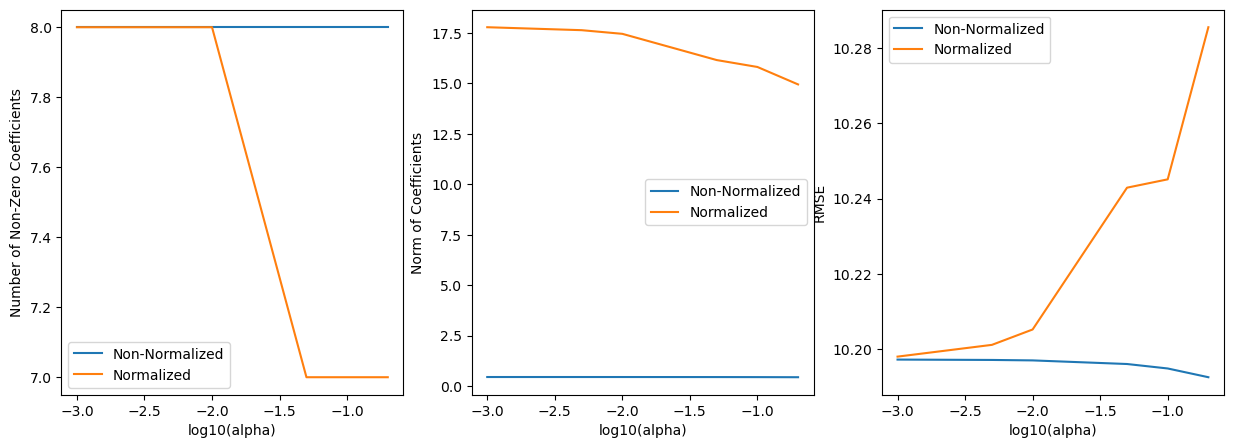

In [50]:
alphas = [1e-3, 5e-3, 0.01, 0.05, 0.1, 0.2]
# Workspace 1.6
#BEGIN 
# code here
concrete_data = data.Concrete()
lasso_non_norm = None
lasso_norm = None

# Initialize lists to store the results for each alpha value
non_zero_coefs_non_norm = []
coef_norm_non_norm = []
rmse_non_norm = []
non_zero_coefs_norm = []
coef_norm_norm = []
rmse_norm = []
for alpha in alphas:
    # Fit the non-normalized model
    lasso_non_norm = Lasso(alpha,normalize=False)
    coefs, norm = lasso_non_norm.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_coefs_non_norm.append(coefs)
    coef_norm_non_norm.append(norm)
    rmse_non_norm.append(lasso_non_norm.evaluate(concrete_data.X_test,concrete_data.y_test))

    # Fit the normalized model
    lasso_norm = Lasso(alpha,normalize=True)
    coefs, norm = lasso_norm.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_coefs_norm.append(coefs)
    coef_norm_norm.append(norm)
    rmse_norm.append(lasso_norm.evaluate(concrete_data.X_test,concrete_data.y_test))

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(np.log10(alphas), non_zero_coefs_non_norm, label='Non-Normalized')
axs[0].plot(np.log10(alphas), non_zero_coefs_norm, label='Normalized')
axs[0].set_xlabel('log10(alpha)')
axs[0].set_ylabel('Number of Non-Zero Coefficients')
axs[0].legend()

axs[1].plot(np.log10(alphas), coef_norm_non_norm, label='Non-Normalized')
axs[1].plot(np.log10(alphas), coef_norm_norm, label='Normalized')
axs[1].set_xlabel('log10(alpha)')
axs[1].set_ylabel('Norm of Coefficients')
axs[1].legend()

axs[2].plot(np.log10(alphas), rmse_non_norm, label='Non-Normalized')
axs[2].plot(np.log10(alphas), rmse_norm, label='Normalized')
axs[2].set_xlabel('log10(alpha)')
axs[2].set_ylabel('RMSE')
axs[2].legend()
#END

#### Workspace 1.6b
#BEGIN

The lowest RMSE for the non normalized model appears to be at alpha = 0.2 while the lowest RMSE for the normalized model appears to be at alpha = 1e-3.

#END

- Q1.7 **[4 points]** (Write-up) Compare the two algorithms on the house prices dataset: compare the number of non-zero coordinates of Ridge vs Lasso and their RMSE on each dataset. Which type of regression is better? When does normalization improve the RMSE?

As clarified on Piazza we are doing this for the concrete dataset not the house prices dataset.

#### Workspace 1.7

#BEGIN

The normalized version of lasso regression has fewer nonzero coefficients for some values of alpha, for the rest they are the same. RMSE is very similar between both models when alpha is held constant, but we see much larger growth in the normalized RMSE in the ridge regression because we test much larger alphas. Neither model had any value of alpha for which normalization improved RMSE.

#END

Lasso is expected to have higher level of sparsity compared to Ridge. On the other hand, when the number of features is very large
(larger than the sample size), Lasso can struggle at picking the right features.
Elastic Net try to combine both types of regularization to get the best of both worlds by minimizing:

\begin{align}
\frac{1}{2N} \sum_i ||y_i - \mathbf{w}^T\mathbf{x}_i -\mathbf{b}||^2_2 + \alpha\beta||\mathbf{w}||_1 + \frac{\alpha}{2}(1 - \beta)||\mathbf{w}||^2_2
\end{align}

where $\beta\in[0,1]$ is the $l_1$ ratio ($\beta=1$ for Lasso and $\beta=0$ for Ridge).

We'll be using [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) from scikit.

- Q1.8 **[3 points]** Complete ElasticNet regression class `Elastic` by implementing fit and evaluate methods with the same signature as Lasso and Ridge. (Again, you can use inheritance)

In [51]:
class ElasticNet(object):
    def __init__(self, alpha, beta=0.5, normalize=False):
        """
        :param alpha: regularization parameter
        :param beta: l1_ratio for ElasticNet
        :param normalize: normalization flag
        """
        self.alpha = alpha
        self.beta = beta
        self.normalize = normalize
        self.scaler = StandardScaler()
        self.coefficients = None
        self.intercept = None
        self._model = linear_model.ElasticNet(alpha=alpha, l1_ratio=beta)

    def fit(self, X, y):
        """
        fit self._model using the provided data and store the coefficients and intercept in 'self.coefficients' and 'self.intercept'
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (n_samples, n_features)
        :param y: target values (n_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """

        num_nonzero_coefs, coefs_norm = 0, 0
        # Workspace 1.8.a
        # TO DO: Complete Elastic Net
        # TO DO: save w and b in 'self.coefficients' and 'self.intercept' respectively
        #BEGIN 
        # code here
        if self.normalize:
            X = self.scaler.fit_transform(X)
        self._model.fit(X, y)
        self.coefficients = self._model.coef_
        self.intercept = self._model.intercept_
        num_nonzero_coefs = np.count_nonzero(self.coefficients)
        coefs_norm = np.linalg.norm(self.coefficients)
        #END
        return num_nonzero_coefs, coefs_norm

    def evaluate(self, test_x, test_y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param test_x: test features
        :param test_y: test target
        :return: RMSE
        """

        root_mean_squared_error = 0
        # TO DO: predict based on the test features and return the mean_squared_error
        # Workspace 1.8.b
        #BEGIN 
        # code here
        if self.normalize:
            test_x = self.scaler.transform(test_x)
        y_pred = self._model.predict(test_x)
        root_mean_squared_error = np.sqrt(np.mean((test_y - y_pred) ** 2))
        #END
        return root_mean_squared_error

In [52]:
# Tests cell, do not remove
%run -i tests elastic

....
----------------------------------------------------------------------
Ran 4 tests in 0.010s

OK


<Figure size 640x480 with 0 Axes>

- Q1.9 **[3 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized `Elastic`:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell, and $\beta= 0.3$. What is the best `alpha` for each version of the two models? How does it compare to the previous models.


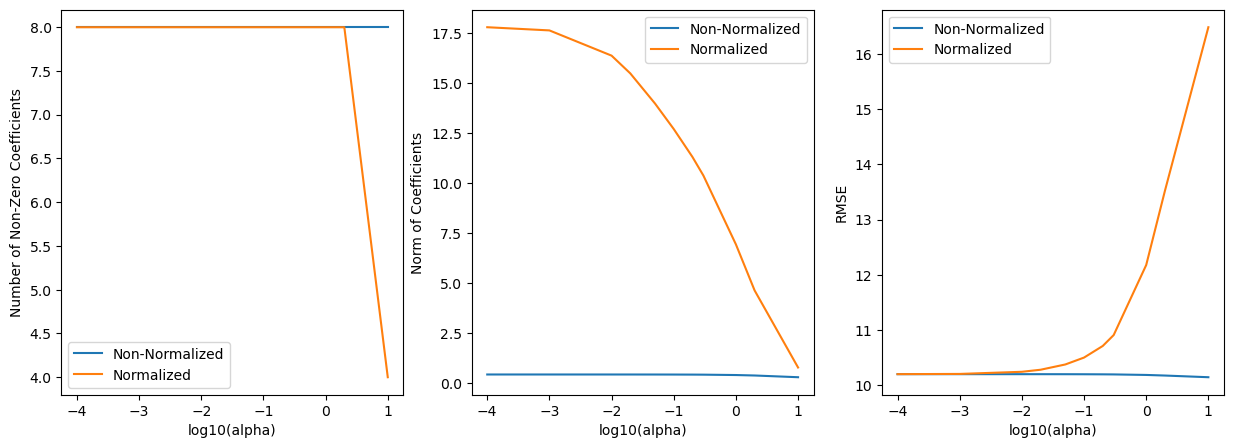

In [53]:
alphas = [1e-4, 1e-3, 1e-2, 0.02, 0.05, 0.1, 0.2, 0.3, 1.0, 2.0, 10.0]
# Workspace 1.2
#BEGIN 
# code here
concrete_data = data.Concrete()
elastic_non_norm = None
elastic_norm = None

# Initialize lists to store the results for each alpha value
non_zero_coefs_non_norm = []
coef_norm_non_norm = []
rmse_non_norm = []
non_zero_coefs_norm = []
coef_norm_norm = []
rmse_norm = []
for alpha in alphas:
    # Fit the non-normalized model
    elastic_non_norm = ElasticNet(alpha,beta=0.3,normalize=False)
    coefs, norm = elastic_non_norm.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_coefs_non_norm.append(coefs)
    coef_norm_non_norm.append(norm)
    rmse_non_norm.append(elastic_non_norm.evaluate(concrete_data.X_test,concrete_data.y_test))

    # Fit the normalized model
    elastic_norm = ElasticNet(alpha,beta=0.3,normalize=True)
    coefs, norm = elastic_norm.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_coefs_norm.append(coefs)
    coef_norm_norm.append(norm)
    rmse_norm.append(elastic_norm.evaluate(concrete_data.X_test,concrete_data.y_test))

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(np.log10(alphas), non_zero_coefs_non_norm, label='Non-Normalized')
axs[0].plot(np.log10(alphas), non_zero_coefs_norm, label='Normalized')
axs[0].set_xlabel('log10(alpha)')
axs[0].set_ylabel('Number of Non-Zero Coefficients')
axs[0].legend()

axs[1].plot(np.log10(alphas), coef_norm_non_norm, label='Non-Normalized')
axs[1].plot(np.log10(alphas), coef_norm_norm, label='Normalized')
axs[1].set_xlabel('log10(alpha)')
axs[1].set_ylabel('Norm of Coefficients')
axs[1].legend()

axs[2].plot(np.log10(alphas), rmse_non_norm, label='Non-Normalized')
axs[2].plot(np.log10(alphas), rmse_norm, label='Normalized')
axs[2].set_xlabel('log10(alpha)')
axs[2].set_ylabel('RMSE')
axs[2].legend()
#END

#### Workspace 1.9.b

#BEGIN

The RMSE is lowest for the normalized version between alpha=1e-4 and alpha=1e-2. The RMSE is lowest for the unnormalized version at alpha=10. Compared to the other models it appears to perform worse because its normalized RMSE grows faster as alpha increases.

#END

- Q1.10 **[2 points]** What are the cons and pros of each of the three types of regressions we have tested?

#### Workspace 1.10

#BEGIN

Pros:
Ridge: prevents underfitting
Lasso: prevents overfitting
Elastic: achieves the desired balance of overfitting and underfitting

Cons:
Ridge: prone to overfitting
Lasso: prone to underfitting, problem selecting features when n >> p
Elastic: computationally expensive


#END

***
## Problem 2: Logistic Regression for Binary Classification (35 points + 6)

The second part of this assignment will be dealing with Logistic Regression.
While the name "regression" suggests otherwise, Logistic Regression is actually used for classification.
It's a regression problem because the targets are the continuous likelihoods of the outcomes.

Our dataset is a binary version of the Housing Prices data where the label is = 1 if the price is higher than the median.

In [54]:
binary_data = data.BinaryPrices()
scaler = MinMaxScaler()
# We MinMax scale the features
binary_data.X_train = scaler.fit_transform(binary_data.X_train)
binary_data.X_test = scaler.transform(binary_data.X_test)

Using the same notations from Problem 1 (this time with discrete targets $y_i$ in {0, 1}), _Logistic Regression_ is about minimizing the **N**egative **L**og **L**ikelihood objective defined as:
\begin{align}
\textrm{NLL}(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\mathbf{w}^T{\mathbf{x_i}}) + (1-y_i)\log(1 - \sigma(\mathbf{w}^T\mathbf{x_i}))\right]
\end{align}

You might be wondering: where is the intercept?. We're including the intercept in $(\mathbf x_i)_i$ since we'll be adding a constant feature $\mathbf x_{i,0} = 1$ to all samples $(\mathbf x_i)_i$.

We will call it the zero-th column and the intercept will be $\mathbf{w}_0$.
This zero-th column will be appended to the training samples in `fit` method and the test samples in `predict` method. $\sigma$ is the sigmoid function seen in class.

The gradient of **NLL** w.r.t $\mathbf{w}$ is:

\begin{align}
\frac{\partial \textrm{NLL}}{\partial \mathbf{w}} = \frac{1}{N} \sum_i \left[\sigma(\mathbf{w}^T\mathbf{x}_i)-y_i)\right]\mathbf{x}_i
\end{align}

- Q2.1.a **[2 points]** Complete the `score` method to return $\langle\mathbf{w}{\mathbf{x_i}}\rangle$
- Q2.1.b **[2 points]** Complete `sigmoid` function to return the sigmoid values $\sigma(\mathbf{w}^T{\mathbf{x_i}})$ given features array.

Notice that we clip the score $\mathbf{w}^T{\mathbf{x_i}}$ to the interval $[-25, 25]$ to avoid overflow of `np.exp`

- Q2.2 **[4 points]** Finish the `compute_gradient` function to return the derivative of the cost w.r.t. the weights
- Q2.3 **[4 points]** Finish the `batch_update` function so that it performs batch gradient descent using the provided batch data
- Q2.4 **[4 points]** Finish the `fit` function so that it performs several training epochs and returns the accuracy score on the validation data at the end of each epoch.

Notice that we initialize $\mathbf{w}$ so that $\mathbf{w}_j = \frac{1}{d}$

- Q2.5 **[3 points]** Finish the `predict` method to return the predicted labels (either 0 or 1)


In [55]:
from sklearn.metrics import accuracy_score


class LogisticRegression:

    def __init__(self, eta=0.1, alpha=0):
        """
        Create a logistic regression classifier
        :param eta: Learning rate
        :param alpha: We will use this parameter later (IN BONUS)
        """

        self.w = None  # uninitialized w
        self.eta = eta  # learning rate
        self.initialized = False  # flag used to initialize w only once, it allows calling fit multiple times
        self.alpha = alpha  # regularization / penalty term (USED IN BONUS)

    def append_ones(self, X):
        # append the 1s columns as feature 0
        return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

    def score(self, x):
        # Workspace 2.1.a
        score = 0
        #BEGIN 
        # code here
        score = np.dot(x, self.w)
        #END
        return score

    def sigmoid(self, x):
        """ Compute Sigmoid
        :param x: features array of shape (num_samples, num_features + 1) (zero-th column appended)
        :return: sigmoid values , of shape (num_samples,)
        """
        # Workspace 2.1.b
        # TO DO: Complete this function to return the output of applying the sigmoid function to the score
        wx = np.clip(self.score(x), -25, 25)
        sigma = None  # Placeholder
        #BEGIN 
        # code here
        sigma = 1 / (1 + np.exp(-wx))
        #END
        return sigma

    def compute_gradient(self, x, y):
        """
        Return the derivative of the cost w.r.t to the weights. Don't forget to average by batch_size
        :param x:  Feature vector, shape (batch_size, num_features +1), with zero-th column appended
        :param y: real binary class label, shape (batch_size)
        :return: gradient of shape (num_features + 1,)
        """

        # Workspace 2.2
        # TO DO: Finish this function to compute the gradient
        gradient = np.zeros((x.shape[1],))
        #BEGIN 
        # code here
        gradient = np.dot(x.T, (self.sigmoid(x) - y)) / x.shape[0]
        #END
        return gradient

    def batch_update(self, batch_X, batch_y):
        """
        Single self.w update using the batch.
        :param batch_X: array of features (includes the constant feature at column 0), of shape (batch_size, num_features + 1)
        :param batch_y: array of target values, shape (batch_size,)
        :return: nothing
        """

        # Workspace 2.3
        #BEGIN 
        # code here
        gradient = self.compute_gradient(batch_X, batch_y)
        self.w = self.w - self.eta * gradient
        #END

    def fit(self, X, y, epochs=1, batch_size=1, validation_X=None, validation_y=None):
        """
        train the LogisticRegression
        :param X: training features, shape (num_samples, num_features)
        :param y: training labels, shape (num_samples,)
        :param epochs: number of epochs, integer
        :param batch_size: size of batch for gradient update, 1 for SGD
        :param validation_X: validation rows, should default to training data if not provided
        :param validation_y: validation labels
        :return: accuracy score at the end of each epoch on validation data
        """

        if validation_X is None:
            validation_X, validation_y = X, y
        metrics = []
        X = self.append_ones(X)

        if not self.initialized:
            self.w = np.ones(X.shape[1]) / X.shape[1]
            self.initialized = True

        # Workspace  2.4
        # TO DO: Process X to append the zero-th constant column and call self.optimize
        # TO DO: Compute average accuracy on the validation data at the end of each epoch
        # HINT: make sure to initialize w
        #BEGIN 
        # code here
        validation_X = self.append_ones(validation_X)
        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
            # get the current batch
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

            # calculate gradient
                grad = self.compute_gradient(X_batch, y_batch)

            # update weights
                self.w = self.w - self.eta * grad

        # calculate accuracy on validation set
            y_pred = self.predict(validation_X)
            accuracy = accuracy_score(validation_y, y_pred)
            metrics.append(accuracy)

        #END
        return np.array(metrics)

    def predict(self, X):
        """
        :param X: features array, shape (num_samples, num_features) (without the constant column)
        :return: predicted binary label, shape (num_samples,)
        """
        # Workspace 2.5
        y_hat = np.zeros((X.shape[0],))
        #BEGIN 
        # code here
        #X = self.append_ones(X)
        scores = X @ self.w
        y_hat = np.round(self.sigmoid(X))
        #END
        return y_hat

    def optimize(self, X, y, batch_size):
        """
        Perform one epoch batch gradient on shuffled data
        :param X: 'np.array' of shape (num_samples, num_features +1), The training data with zero-th column appended
        :param y: target values of shape (num_samples,)
        :param batch_size: batch_size of the batch_update
        :return: None
        """

        indices = np.random.permutation(len(X))  # used to shuffle the data
        for i in range(0, X.shape[0], batch_size):
            batch_x = X[indices[i:i + batch_size]]
            batch_y = y[indices[i:i + batch_size]]
            self.batch_update(batch_x, batch_y)

After completing the class above, loop over the training data and perform batch training with `batch_size=1`(Stochastic Gradient Descent) for 50 epochs, and different values of eta ( see `etas`). Train your model and do the following:

- Q2.6 **[5 points]** Plot the accuracy trend for the different values of eta on the training data (epoch vs accuracy). (reset random seed for each loop to mitigate the randomness effect)

Use the values provided below

0.001
0.01
0.1
1


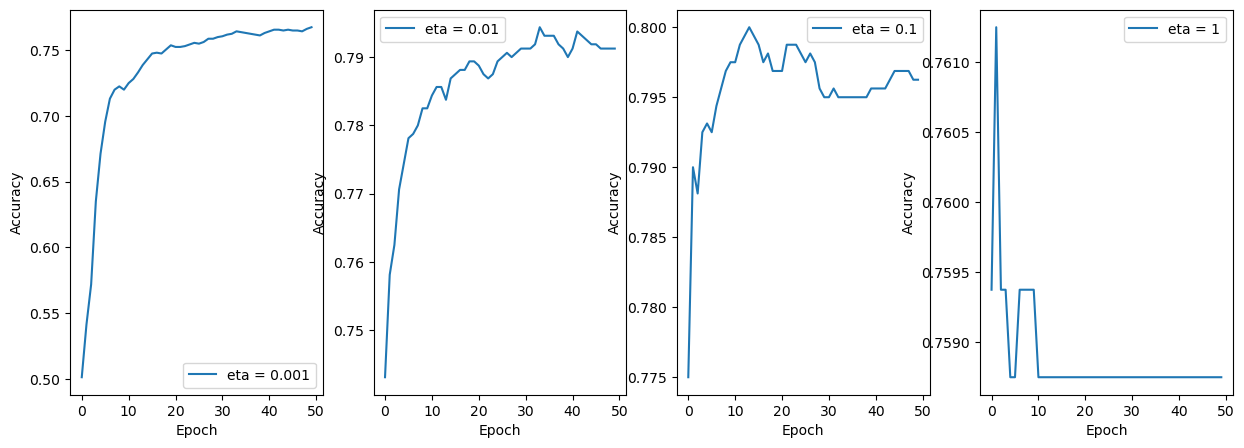

In [56]:
etas = [.001, .01, 0.1, 1]
x=0
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for eta in etas:
    print(eta)
    np.random.seed(2022)  # Reset randomness
    # Workspace 2.6
    #BEGIN 
    L = LogisticRegression(eta=eta)
    accuracies = L.fit(binary_data.X_train,binary_data.y_train,epochs=50)
    axs[x].plot(accuracies, label='eta = '+str(eta))
    axs[x].set_xlabel('Epoch')
    axs[x].set_ylabel('Accuracy')
    axs[x].legend()
    x+=1
    #END
plt.legend()
plt.show()


- Q2.7 **[4 points]** Plot the accuracy trend for the different values of eta on the test data. (reset random seed for each loop to mitigate the randomness effect)

0.0001
0.001
0.01
1


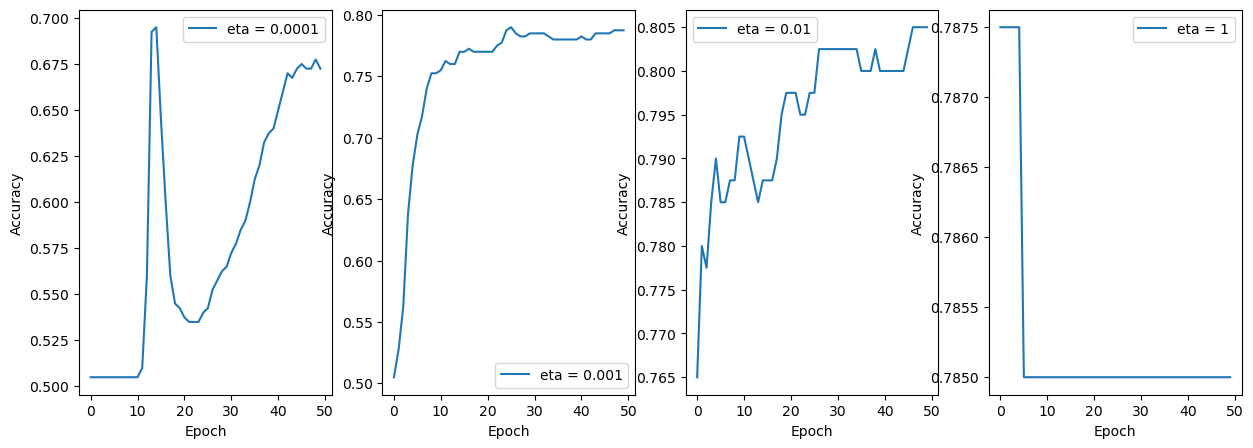

In [57]:
etas = [.0001, .001, .01, 1]
x=0
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for eta in etas:
    print(eta)
    np.random.seed(2023)  # Reset randomness
    # Workspace 2.7
    # Generate random data
    L = LogisticRegression(eta=eta)
    accuracies = L.fit(binary_data.X_train,binary_data.y_train,epochs=50,validation_X=binary_data.X_test,validation_y=binary_data.y_test)
    axs[x].plot(accuracies, label='eta = '+str(eta))
    axs[x].set_xlabel('Epoch')
    axs[x].set_ylabel('Accuracy')
    axs[x].legend()
    x+=1
plt.legend()
plt.show()


This time we want to analyze the effect of varying the batch size. We fix `eta=0.01` and `epochs=50` and we want to
examine the accuracy on the test set at the end of the training.

- Q2.8 **[4 points]** Produce a plot of the accuracy on the test data at the end of the training as a function of the batch size. Reset the random generator for each iteration.

Use batch sizes provided below

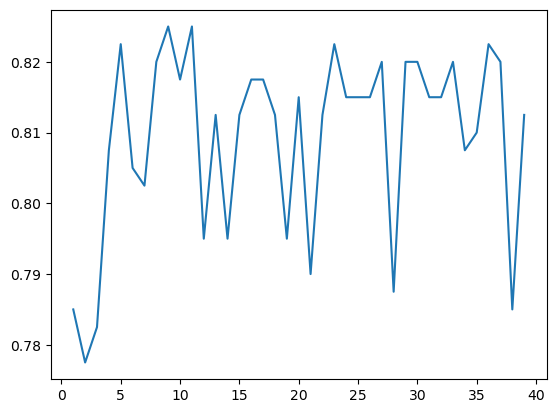

In [58]:
batch_sizes = list(range(1, 40))
accs = []

for b_size in batch_sizes:
    np.random.seed(2022)
    # Workspace 2.8
    #BEGIN 
    L = LogisticRegression(eta=eta)
    accuracies = L.fit(binary_data.X_train,binary_data.y_train,epochs=50,batch_size=b_size,validation_X=binary_data.X_test,validation_y=binary_data.y_test)
    accs.append(accuracies[len(accuracies)-1])
    #END

plt.plot(batch_sizes, accs)
plt.show()


- Q2.9 **[3 points]** How does the learning rate (eta) and the number of epochs affect the performance of the classifier.

#### Workspace 2.9

#BEGIN

On the training data, performanced increased throughout 50 epochs for eta = 0.001 and 0.01, it increased until about 10 epochs then started decreasing for eta=0.1, and it decreased after just one epoch for eta=1. The test data was similar except for eta=0.001, for which performance peaked around 10 epochs, dropped until around 20 epochs then started to rise again.

#END

2.10 (**Bonus**) **[6 points]** Since we're done with the binary regression, we will try to add Ridge regularization:
\begin{align}
\textrm{NLL}(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\langle\mathbf{w}, {\mathbf{x}_i}\rangle) + (1-y_i)\log(1 - \sigma(\langle\mathbf{w}, \mathbf{x}_i))\rangle\right] + \alpha {||\mathbf{w}||^2}_{\geq1}
\end{align}

This is exactly what we will be using the `alpha` parameter in `LogisticRegression` for.
- First, write the gradient formula in the cell below
- Edit your `compute_gradient` to account for the regularization term. Note that the regularization $||\mathbf{w}||^2$ does not apply to the intercept $\mathbf{w}_0$

#### Workspace 2.10

#BEGIN

% YOUR ANSWER HERE

#END


## Problem 3: Naive Bayes Classifier (25 points + 4)
***
Consider the problem of predicting whether your TA will be late to campus in the morning based off the weather, temperature, and whether they biked or took the bus.
The dataset looks like the following:

|Snowing |Raining |Below Freezing |Bike or Bus |Late |
|:------:|:-----------:| :----------:| :----------:|--:|
| Yes | No | Yes | Bus  | Yes |
| No | No | No | Bicycle | No |
| No | Yes | No | Bicycle | Yes |
| No | No | No | Bus | Yes |
| No | No | No | Bicycle | No |
| No | No | Yes | Bicycle | No |
| No | No | Yes | Bicycle | Yes |
| Yes | Yes | Yes | Bus | No |
| No | Yes | No | Bus | Yes |
| No | Yes | No | Bicycle | No |
| No | No | No | Bicycle | No |
| Yes | No | Yes | Bicycle | Yes |

In [59]:
features = np.array([
    [1, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 1, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 1],
    [0, 0, 1, 1],
    [1, 1, 1, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 1],
    [0, 0, 0, 1],
    [1, 0, 1, 1]
])
labels = np.array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1])

- Q3.1 **[4 points]** If we were to use only one binary feature (Snowing, Raining, Below Freezing, Bike or Bus)
then what's the highest accuracy we could achieve? Which feature should we use?

Hint:Using a single feature is equivalent to using a decision tree of depth = 1.

### Workspace 3.1

#BEGIN

P(Late | Snowing) = 0.67
P(Late | not snowing) = 0.44
Accuracy for Snowing -> late and not snowing -> not late: 7/12 = 58%
P(Late | Raining) = 0.5
P(Late | not raining) = 0.5
Accuracy for raining -> late and not raining -> not late (or vice versa): 6/12 = 50%
P(Late | Below freezing) = 0.6
P(Late | not below freezing) = 0.43
Accuracy for below freezing -> late and not below freezing -> not late: 7/12 = 58%
P(Late | Bike) = 0.375
P(Late | Bus) = 0.75
Accuracy for bus -> late and bike -> not late: 8/12 = 67%

We should use Bike or Bus because splitting on it using bus -> late and bike -> not late results in the highest possible accuracy of any single feature split.

#END

## How to implement NaiveBayes
As seen during the class, given a sample $x=(x_1, x_2, x_3)$ (3 features), the naive Bayes classifier should assign the label $y$ that maximizes:

\begin{align}
\log [p(y) \prod_i p(x_i | y)] = \log p(y) + \sum_{i} \log p(x_i | y)
\end{align}

$p(y)$ and $p(x_i | y)$ are computed using the training set (during `fit` call).

For this, we need two attributes to store $\log p(y)$ and $\log p(x_i | y)$ for different features $x_i$.

Let's assume we're working with binary classes $\{0, 1\}$ and all features have discrete supports.
Then we will store `classes_log_probability` as an array of shape `(2,)` that contains:
\begin{bmatrix}
\log p(y=0),\log p(y=1)
\end{bmatrix}.

If feature $i$ has $2$ possible values $\{0, 1\}$, then $\log p(x_i | y)$ would be stored as a $ 2 \times 2$ matrix:
\begin{align}
A_i = \begin{bmatrix}
\log p(x_i=0 | y=0) & \log p(x_i=1| y=0)\\
\log p(x_i=0 | y=1) & \log p(x_i=1 | y=1)
\end{bmatrix}
\end{align}

`features_log_likelihood` should then store such matrix for each feature (feature index as the key).

We have defined $p(x_i | y)$ as :
\begin{align}
p(x_i | y) = \frac{N_{y,x_i}}{N_y}
\end{align}
where $N_{y,i}$ is the number of rows where $y$ and $x_i$ occur together, and $N_y = \sum_i N_{y,x_i}$.

- Q3.2 **[5 points]** Complete the method `compute_classes` and store the log prior in `classes_log_probability` (Avg __2__)

- Q3.3 **[6 points]** Complete the method `compute_features` by storing the matrices $A_i$ in `self.features_log_likelihood` (Avg __4.3__)

Study the method `joint_log_likelihood`. You will need to use this to complete Naive Bayes. Note that it computes the likelihood quantities
 $[\sum_{i} \log p(x_i | y=0), \sum_{i} \log p(x_i | y=1)]$ for each sample

- Q3.4 **[5 points]** Complete the `predict` method

In [60]:
import numpy as np

class NaiveBayes(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """

    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = None
        self.classes_log_probability = np.empty((2,))
        self.features_log_likelihood = {}  # list of arrays where element i store log p(X[:,i], y)

    def compute_classes(self, y):
        """
        Computes the log prior of binary classes and stores the result in self.classes_log_probability
        :param y: binary labels array, shape (m,)
        """
        m = y.shape[0]
        self.classes_counts = np.bincount(y, minlength=2)
        self.classes_log_probability[0] = np.log((self.classes_counts[0] + self.alpha) / (m + 2*self.alpha))
        self.classes_log_probability[1] = np.log((self.classes_counts[1] + self.alpha) / (m + 2*self.alpha))

    def compute_features(self, X, y):
        """
        Computes the log likelihood matrices for different features and stores them in self.features_log_likelihood
        :param X: data matrix with binary features, shape (n_samples, n_features)
        :param y: binary labels array, shape (n_samples,)
        """
        for f in range(X.shape[1]):
            self.features_log_likelihood[f] = np.zeros((2, 2))
            for c in range(2):
                mask = y == c
                # Compute log-likelihoods for the feature f and class c
                p0 = (np.sum(X[mask, f] == 0) + self.alpha) / (np.sum(mask) + 2*self.alpha)
                p1 = (np.sum(X[mask, f] == 1) + self.alpha) / (np.sum(mask) + 2*self.alpha)
            # Store the log-likelihoods in the correct format
                self.features_log_likelihood[f][c][0] = np.log(p0 if c == 0 else p1) # log𝑝(𝑥𝑖=0|𝑦=0) or log𝑝(𝑥𝑖=0|𝑦=1)
                self.features_log_likelihood[f][c][1] = np.log(p1 if c == 0 else p0) # log𝑝(𝑥𝑖=1|𝑦=0) or log𝑝(𝑥𝑖=1|𝑦=1)

    def fit(self, X, y):
        """ fit Bayes
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :param y: corresponding binary labels of shape (n_samples,) [values 0 or 1]
        :return: Classifier
        """
        self.compute_classes(y)
        self.compute_features(X, y)
        return self

    def joint_log_likelihood(self, X):
        """
        Computes the joint log likelihood
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :return: joint log likelihood array jll of shape (n_samples, 2), where jll[i] = [log p(X[i]|y=0),log p(X[i]|y=1)]
        """
        joint_log_likelihood = np.zeros((X.shape[0], self.classes_log_probability.shape[0]))
        for f in self.features_log_likelihood:
            joint_log_likelihood += self.features_log_likelihood[f][:, X[:, f]].T
        return joint_log_likelihood

    def predict(self, X):
        """
        :param X:
        :return:
        """
        jll = self.joint_log_likelihood(X)
        return np.argmax(jll + self.classes_log_probability, axis=1)


In [61]:
%run -i tests naivebayes

....
----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


<Figure size 640x480 with 0 Axes>

- Q3.5 **[5 points]** Evaluate (accuracy) the NaiveBayes classifier on the training data. Does it outperform our baseline (of using one feature)?

In [62]:
naive_bayes = NaiveBayes()
# Workspace 3.5
#TODO: Transform features to binary features, fit the classifier, report the accuracy
#BEGIN 
# code here
# instantiate the NaiveBayes classifier
nb = NaiveBayes()

# fit the model on the training data
nb.fit(features, labels)

# predict the labels of the training data
y_pred = nb.predict(features)

# calculate accuracy score
accuracy = accuracy_score(labels, y_pred)

print("Accuracy on training data:", accuracy)
#END

Accuracy on training data: 0.6666666666666666


It has the same accuracy (8/12) as the baseline model with one feature.

**Bonus**

- Q3.6 **[4 points]** Use the attribute `alpha` of the NaiveBayes to convert it to smoothed NaiveBayes presented during the class.

`alpha` defaults to 0, so editing the class should not affect NaiveBayes tests